In [7]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Load CSV from the correct path
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

# Display first few rows
print("📄 First 5 rows of train.csv:")
print(df.head())




📄 First 5 rows of train.csv:
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


In [9]:
#Check for missing values
print("\n🧪 Missing values:")
print(df.isnull().sum())


🧪 Missing values:
image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64


In [10]:
print(df.columns)

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [11]:
# Convert one-hot encoded label columns into a single 'label' column
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
df['label'] = df[label_cols].idxmax(axis=1)

# Check the first few rows
print(df.head())

# Check label distribution
print("\n Label distribution:")
print(df['label'].value_counts())

  image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

 Label distribution:
label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64


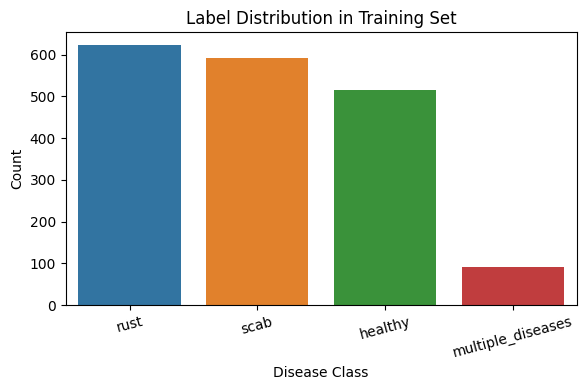

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Label Distribution in Training Set")
plt.xlabel("Disease Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

What each part does:
1.Loops over every image in the dataset.

2.Reads each image using OpenCV.

3.Resizes to 128x128 (so all images are the same size).

4.Converts to HSV color space (good for color-based tasks like plant disease).

5.Computes a 3D color histogram with 8×8×8 bins → gives a 512-dim feature vector.

6.Flattens it to 1D and adds to the features list.

7.Also appends the image’s label to labels.

In [13]:
import cv2
import numpy as np
from tqdm import tqdm

# Image folder path
img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'

# Function to extract color histogram features from an image
def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize to fixed size
    
    # Convert to HSV and compute color histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Flatten to 1D feature vector
    return hist

# Extract features for all training images
features = []
labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row['image_id']
    label = row['label']
    img_path = os.path.join(img_dir, img_id + '.jpg')
    
    feat = extract_features(img_path)
    features.append(feat)
    labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)


100%|██████████| 1821/1821 [00:57<00:00, 31.65it/s]


X.shape = (1821, 512) → 512 handcrafted features per image

y.shape = (1821,) → corresponding disease labels

Fix Class Imbalance with RandomOverSampler(Manual)

In [14]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.utils import resample

# Convert to DataFrame for easier manipulation
df_balanced = pd.DataFrame(X)
df_balanced['label'] = y

# Count original class distribution
print("Before oversampling:", dict(df_balanced['label'].value_counts()))

# Separate by class
grouped = [df_balanced[df_balanced['label'] == label] for label in df_balanced['label'].unique()]

# Find max class size
max_count = max([len(g) for g in grouped])

# Resample each class to max_count
resampled_groups = [resample(g, replace=True, n_samples=max_count, random_state=42) for g in grouped]

# Concatenate all resampled classes
df_oversampled = pd.concat(resampled_groups)

# Shuffle
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate X and y
X_resampled = df_oversampled.drop(columns=['label']).values
y_resampled = df_oversampled['label'].values

# Show new class distribution
print("After oversampling:", dict(pd.Series(y_resampled).value_counts()))


Before oversampling: {'rust': 622, 'scab': 592, 'healthy': 516, 'multiple_diseases': 91}
After oversampling: {'multiple_diseases': 622, 'healthy': 622, 'rust': 622, 'scab': 622}


In [15]:
from sklearn.model_selection import train_test_split

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 1990, Test size: 498


**Random Forest**

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

Accuracy: 0.9558232931726908

Classification Report:
                    precision    recall  f1-score   support

          healthy       0.89      0.95      0.92       125
multiple_diseases       1.00      1.00      1.00       124
             rust       0.99      0.97      0.98       125
             scab       0.94      0.90      0.92       124

         accuracy                           0.96       498
        macro avg       0.96      0.96      0.96       498
     weighted avg       0.96      0.96      0.96       498



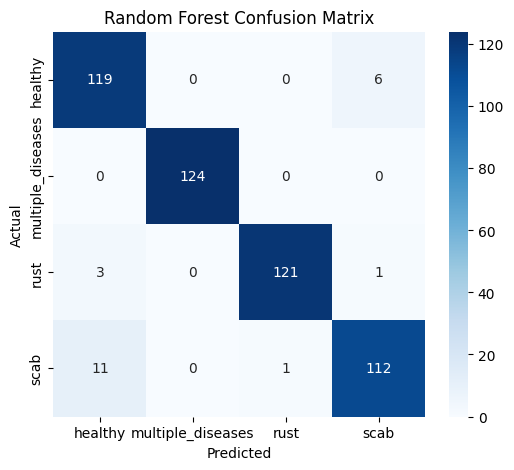

In [18]:

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [19]:
import joblib
joblib.dump(rf, 'random_forest_plant_classifier.pkl')

['random_forest_plant_classifier.pkl']

Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                    cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validated Accuracy: 0.9241263697323229


In [21]:
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [22]:
# Predict again on the test set
y_pred = best_rf.predict(X_test)

# Evaluate again
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9698795180722891

Classification Report:
                    precision    recall  f1-score   support

          healthy       0.94      0.95      0.94       125
multiple_diseases       1.00      1.00      1.00       124
             rust       0.99      0.98      0.99       125
             scab       0.95      0.94      0.95       124

         accuracy                           0.97       498
        macro avg       0.97      0.97      0.97       498
     weighted avg       0.97      0.97      0.97       498



Creates a confusion matrix (actual vs predicted labels).

Uses a heatmap to visualize it:

Darker squares on the diagonal = correct predictions

Off-diagonal = misclassifications

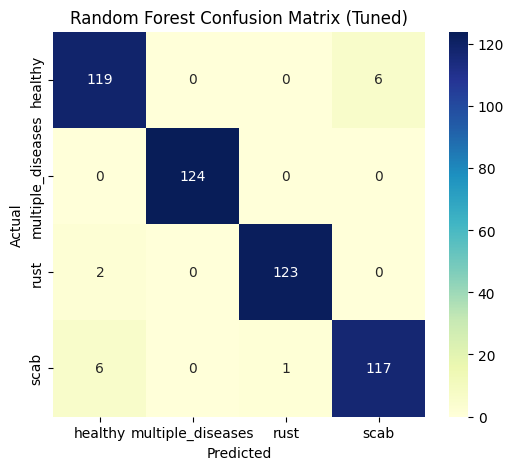

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_rf.classes_,
            yticklabels=best_rf.classes_, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (Tuned)")
plt.show()


In [24]:
import joblib

# Save the model
joblib.dump(best_rf, 'random_forest_tuned_model.pkl')


['random_forest_tuned_model.pkl']

**SVM**

 1. Import and Train the SVM

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Encode string labels to numeric
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train SVM model (RBF kernel with C=10, gamma=0.1)
svm_model = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm_model.fit(X_train_scaled, y_train_enc)

SVC(C=10, gamma=0.1, random_state=42)

In [26]:
# Predict and evaluate
y_pred = svm_model.predict(X_test_scaled)

# Accuracy and classification report
accuracy = accuracy_score(y_test_enc, y_pred)
print(f" SVM Accuracy: {accuracy:.4f}")
print("\n Classification Report (SVM):\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


 SVM Accuracy: 0.8353

 Classification Report (SVM):

                   precision    recall  f1-score   support

          healthy       1.00      0.68      0.81       125
multiple_diseases       1.00      1.00      1.00       124
             rust       0.61      0.98      0.75       125
             scab       0.95      0.68      0.79       124

         accuracy                           0.84       498
        macro avg       0.89      0.84      0.84       498
     weighted avg       0.89      0.84      0.84       498



Hyperparameter Tuning

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Step 1: Encode string labels to numeric
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Step 2: Compute class weights
class_weights = dict(zip(
    np.unique(y_train_enc),
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train_enc), y=y_train_enc)
))

# Step 3: Scale features (SVM is scale-sensitive)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define hyperparameter grid
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 'scale'],
    'kernel': ['rbf']
}

# Step 5: Create and run GridSearchCV
svm = SVC(class_weight=class_weights)

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train_enc)

# Step 6: Evaluate the best model
print(" Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

print("\n🎯 Accuracy (Tuned SVM):", accuracy_score(y_test_enc, y_pred))
print("\n📊 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
 Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validated Accuracy: 0.8577931636046449

🎯 Accuracy (Tuned SVM): 0.929718875502008

📊 Classification Report:

                   precision    recall  f1-score   support

          healthy       0.87      0.94      0.90       125
multiple_diseases       0.98      1.00      0.99       124
             rust       0.96      0.90      0.93       125
             scab       0.92      0.88      0.90       124

         accuracy                           0.93       498
        macro avg       0.93      0.93      0.93       498
     weighted avg       0.93      0.93      0.93       498



In [30]:
import joblib

# Save the best SVM model
joblib.dump(best_svm, 'Tuned_svm_model.pkl')

# Save the label encoder and scaler too
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

**Gradient Boosting Classifier**

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the Gradient Boosting model
gbm = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gbm.fit(X_train, y_train)


GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

In [32]:
# Predict
y_pred = gbm.predict(X_test)

# Accuracy
print("Accuracy (GBM):", accuracy_score(y_test, y_pred))

# Classification report
print("\n Classification Report (GBM):\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy (GBM): 0.9738955823293173

 Classification Report (GBM):

                   precision    recall  f1-score   support

          healthy       0.93      0.98      0.96       125
multiple_diseases       0.99      1.00      1.00       124
             rust       0.99      0.98      0.99       125
             scab       0.98      0.93      0.95       124

         accuracy                           0.97       498
        macro avg       0.97      0.97      0.97       498
     weighted avg       0.97      0.97      0.97       498



In [35]:
import joblib

# Save the model
joblib.dump(gbm, 'gradient_boosting_model.pkl')
joblib.dump(le, 'label_encoder.pkl')  # Save LabelEncoder for decoding predictions


['label_encoder.pkl']